In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F, BCELoss
import seaborn as sns
import matplotlib.pyplot as plt

traindata = datasets.MNIST(root='./data', train=True, download=True)
valdataset = datasets.MNIST(root='./data', train=False, download=True)



In [ ]:
balanced_train_data = []; balanced_train_targets = []
for i in range(10):
    labelimgs = [labelimage for labelimage, label in traindata if label == i][:1000]
    for image in labelimgs:
        image = (transforms.ToTensor()(image.resize((14,14)))>0.5).float()
        balanced_train_data.append(image)
    balanced_train_targets.append(torch.ones(len(labelimgs))*i)
balanced_train_data = torch.cat(balanced_train_data)
balanced_train_targets = torch.cat(balanced_train_targets)


valdata = []; valtargets = []

for image, label in valdataset:
    image = (transforms.ToTensor()(image.resize((14,14)))>0.5).float()
    valdata.append(image)
    valtargets.append(torch.tensor(label))
valdata = torch.cat(valdata)
valtargets = torch.tensor(valtargets)
valdataset.data = valdata
valdataset.targets = valtargets
print(balanced_train_data.shape, balanced_train_targets.shape)
print(valdata.shape, valtargets.shape)

In [ ]:
dataloader = DataLoader(list(zip(balanced_train_data, balanced_train_targets)), batch_size=32, shuffle=True)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        """Encoder layers"""
        self.linear1 = nn.Linear(196, 128)
        self.linear2 = nn.Linear(128, 16)  
        """Decoder layers"""
        self.linear3 = nn.Linear(8, 128)
        self.linear4 = nn.Linear(128, 196)

    def encode(self, x):
        layer1 = torch.tanh(self.linear1(x))
        encoder_ouputs = self.linear2(layer1)
        mu = encoder_ouputs[:, :8]
        logsigma = encoder_ouputs[:, 8:]
        return mu, logsigma

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5*logsigma)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, latent_factor):
        decodelayer1 = torch.tanh(self.linear3(latent_factor))
        return torch.sigmoid(self.linear4(decodelayer1))

    def forward(self, x):
        mu, logsigma = self.encode(x.view(-1, 196))
        latent_factor = self.reparameterize(mu, logsigma)
        return self.decode(latent_factor), mu, logsigma

In [ ]:
def loss_function(recon_x, x, mu, logsigma):
    BCE_Loss = F.binary_cross_entropy(recon_x, x.view(-1, 196), reduction='sum')
    KL_Divergence = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return BCE_Loss, KL_Divergence

In [6]:
VariationalAE = VAE()
optimizer = torch.optim.Adam(VariationalAE.parameters())
train_losses = []
BCE_losses = []
KLD_losses = []
epochs = 50
for epoch in range(epochs):
    VariationalAE.train()
    train_loss = 0
    for _, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = VariationalAE(data)
        BCE_loss, KL_Divergence = loss_function(recon_batch, data, mu, logvar)
        loss = BCE_loss + KL_Divergence
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        BCE_losses.append(BCE_loss.item())
        KLD_losses.append(KL_Divergence.item())
    print(f'Epoch: {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.3f}')
    train_losses.append(train_loss / len(dataloader.dataset))

Epoch: 44, Loss: 33.647
Epoch: 45, Loss: 33.639
Epoch: 46, Loss: 33.574
Epoch: 47, Loss: 33.568
Epoch: 48, Loss: 33.468
Epoch: 49, Loss: 33.477
Epoch: 50, Loss: 33.495


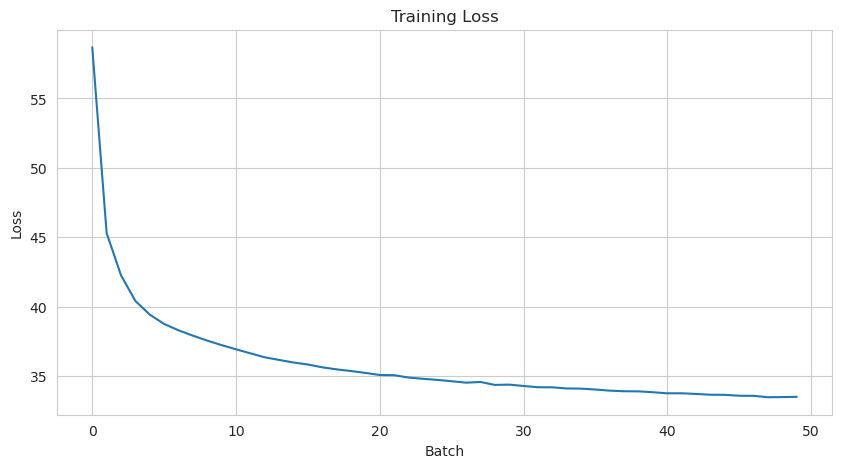

In [7]:

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")  # Set seaborn style
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.savefig("Training_Loss.png")
plt.show()

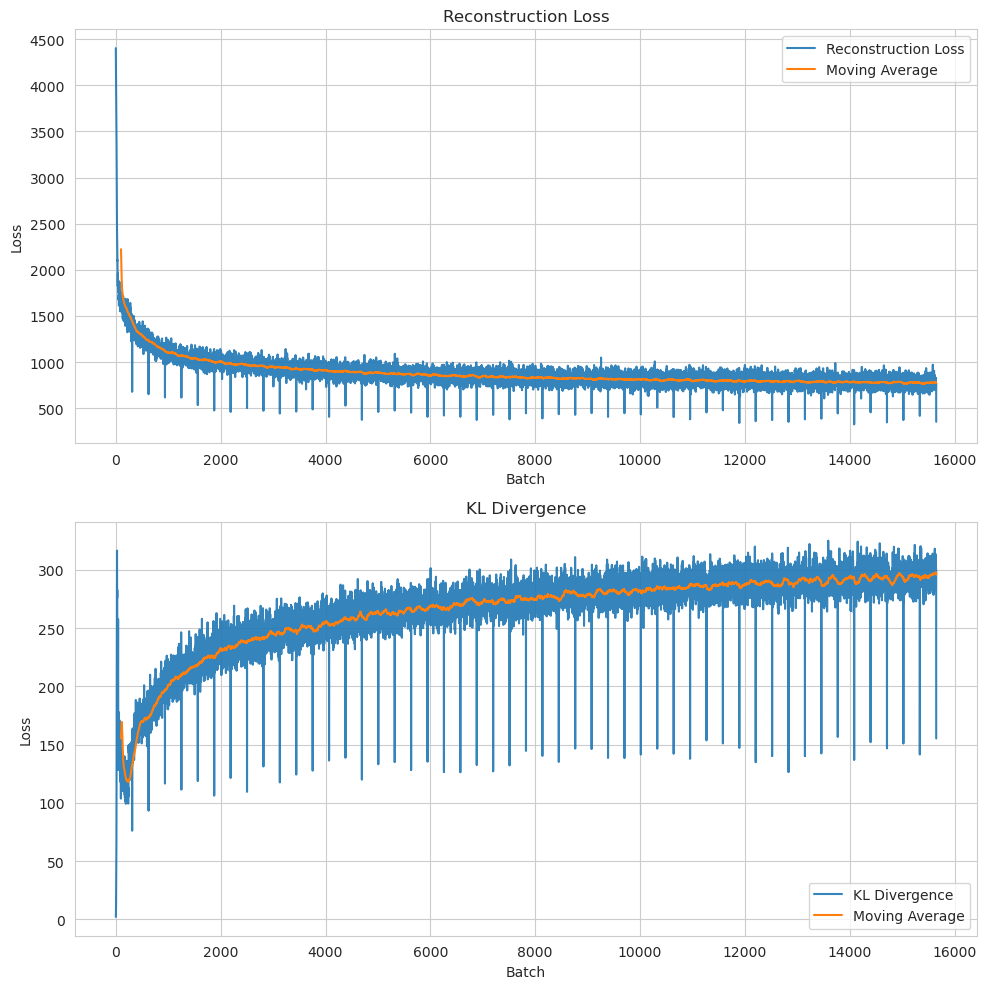

In [8]:
import pandas as pd
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")

plt.subplot(2, 1, 1)
plt.plot(BCE_losses, label='Reconstruction Loss', alpha=0.9)
plt.plot(pd.Series(BCE_losses).rolling(window=100).mean(), label='Moving Average')
plt.title("Reconstruction Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(KLD_losses, label='KL Divergence', alpha=0.9)
plt.plot(pd.Series(KLD_losses).rolling(window=100).mean(), label='Moving Average')
plt.title("KL Divergence")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

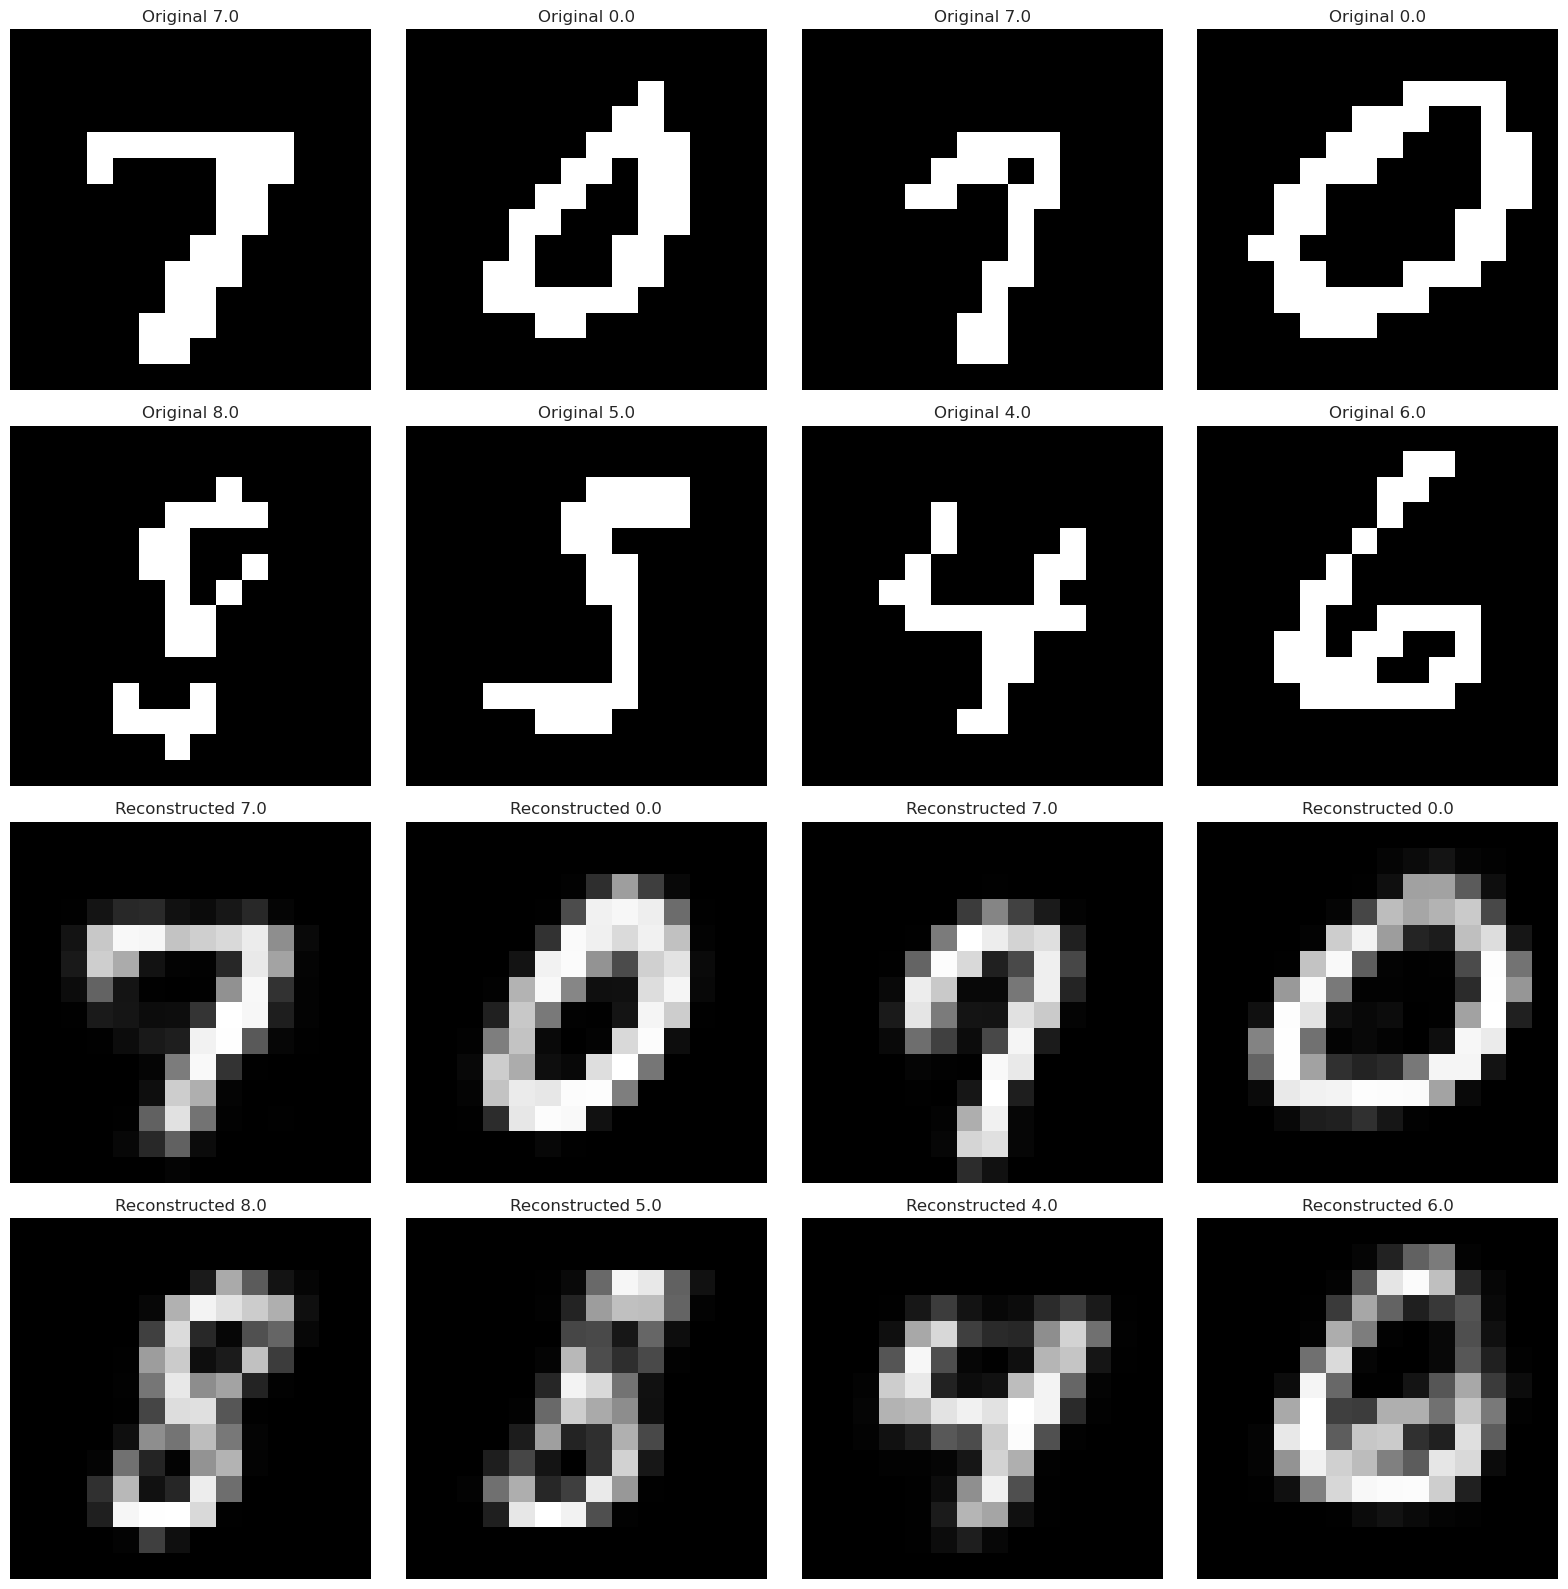

In [9]:
images, labels = next(iter(dataloader))
images = images[:8]
labels = labels[:8]

# Run the images through the autoencoder
recon_images, _, _ = VariationalAE(images)

# Convert the images to numpy arrays
images = images.detach().numpy()
recon_images = recon_images.detach().numpy()

# Plot the original and reconstructed images side by side
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i in range(8):
    # Original images
    axs[i//4, i%4].imshow(images[i].reshape(14, 14), cmap='gray')
    axs[i//4, i%4].set_title(f'Original {labels[i]}')
    axs[i//4, i%4].axis('off')
    # Reconstructed images
    axs[(i+8)//4, (i+8)%4].imshow(recon_images[i].reshape(14, 14), cmap='gray')
    axs[(i+8)//4, (i+8)%4].set_title(f'Reconstructed {labels[i]}')
    axs[(i+8)//4, (i+8)%4].axis('off')

plt.tight_layout()
plt.show()

# for i in range(8):
#     # Original images
#     axs[0, i].imshow(images[i].reshape(14, 14), cmap='gray')
#     axs[0, i].set_title(f'Original {labels[i]}')
#     axs[0, i].axis('off')
#     # Reconstructed images
#     axs[1, i].imshow(recon_images[i].reshape(14, 14), cmap='gray')
#     axs[1, i].set_title(f'Reconstructed {labels[i]}')
#     axs[1, i].axis('off')

# plt.tight_layout()
# plt.show()

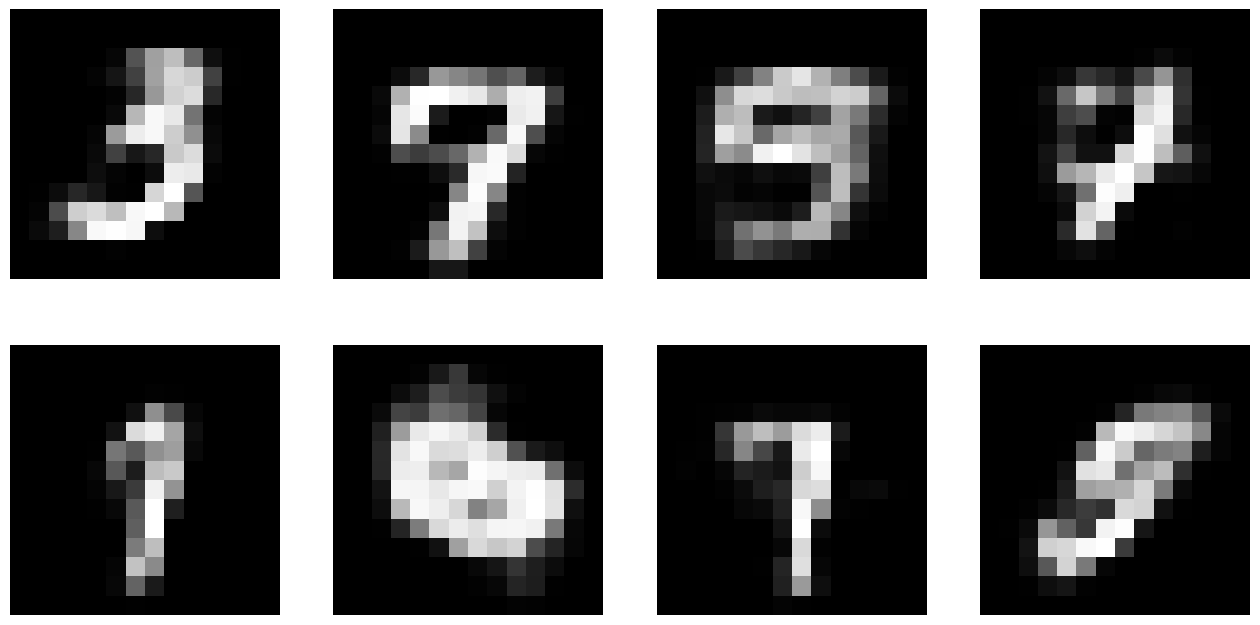

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Sample z from a standard Gaussian distribution
z = torch.randn(8, 8)

# Run the decoder network to synthesize an image
syn_images = VariationalAE.decode(z)

# Convert the synthesized images to numpy arrays
syn_images = syn_images.detach().numpy()

# Plot the synthesized images
for i in range(8):
    axs[i//4, i%4].imshow(syn_images[i].reshape(14, 14), cmap='gray')
    axs[i//4, i%4].axis('off')

plt.show()

In [11]:
val_dataloader = DataLoader(valdata, batch_size=100, shuffle=True)

def validate(VariationalAE, dataloader):
    VariationalAE.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in (dataloader):
            data = batch[0]
            recon_batch, mu, logvar = VariationalAE(data)
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)
            val_loss += BCE.item() + KLD.item()
    return val_loss / len(dataloader.dataset)

all_train_losses = []
all_val_losses = []
update_count = 0

for epoch in range(1, 51):
    for batch in (dataloader):
        data = batch[0]
        optimizer.zero_grad()
        recon_batch, mu, logvar = VariationalAE(data)
        BCE, KLD = loss_function(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        all_train_losses.append(BCE.item()/len(dataloader))
        
        update_count += 1
        if update_count % 100 == 0:
            val_loss = validate(VariationalAE, val_dataloader)
            all_val_losses.append(val_loss/len(val_dataloader))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(all_train_losses[:-50], label='Train Loss')  # Exclude the last value
plt.title("Training Loss")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(0, len(all_train_losses[:-50]), 100), all_val_losses, label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()